In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

2025-05-24 08:55:02.827303: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 08:55:02.849391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748057102.871758  281691 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748057102.882567  281691 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748057102.902104  281691 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for multi-class segmentation"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice loss for segmentation"""
    return 1 - dice_coefficient(y_true, y_pred, smooth)

def focal_loss(gamma=2., alpha=0.25):
    """Focal loss to handle class imbalance"""
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=1))
    return focal_loss_fixed

def combined_loss(y_true, y_pred):
    """Combined loss: Dice + Focal Loss"""
    return dice_loss(y_true, y_pred) + focal_loss()(y_true, y_pred)

# IoU Metric
def iou_metric(y_true, y_pred, smooth=1e-6):
    """Intersection over Union metric"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Improved Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.5
    else:
        return lr * 0.1

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Lightweight U-Net Model
def lightweight_unet_model(input_size=(None, None, 1), target_size=(128, 128)):
    inputs = Input(input_size, name="input_layer")
    
    # Preprocessing
    x = tf.keras.layers.Resizing(target_size[0], target_size[1], name="resize")(inputs)
    x = tf.keras.layers.Rescaling(1./255, name="rescale")(x)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', name="encoder_conv1")(x)
    c1 = BatchNormalization(name="encoder_bn1")(c1)
    p1 = MaxPooling2D((2, 2), name="encoder_pool1")(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', name="encoder_conv2")(p1)
    c2 = BatchNormalization(name="encoder_bn2")(c2)
    p2 = MaxPooling2D((2, 2), name="encoder_pool2")(c2)
    
    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', name="bottleneck_conv")(p2)
    
    # Decoder
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name="decoder_up1")(c3)
    u4 = concatenate([u4, c2], name="decoder_concat1")
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same', name="decoder_conv1")(u4)
    c4 = BatchNormalization(name="decoder_bn1")(c4)
    
    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name="decoder_up2")(c4)
    u5 = concatenate([u5, c1], name="decoder_concat2")
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same', name="decoder_conv2")(u5)
    c5 = BatchNormalization(name="decoder_bn2")(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid', name="output_layer")(c5)
    
    model = Model(inputs, outputs, name="lightweight_unet")
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [2]:
def load_images_label_pairs(images, labels, user_dir):
    image_files = sorted(os.listdir(user_dir))
    print(f"Found {len(image_files)} files in {user_dir}")

    images = []
    labels = []

    image_files = [x for x in image_files if x.endswith('.png')]

    for i in range(len(image_files)):
        image_files[i] = os.path.join(user_dir, image_files[i])
        label_file = image_files[i].replace('.png', '.npy')

        img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)  # Adjust if images are colored
        images.append(img)


        label = np.load(label_file)  # Load the corresponding label
        label = cv2.resize(label, (128, 128))  # Resize to match the image size
        labels.append(label)

    return images, labels
    # return np.array(images), np.array(labels)

In [3]:
images, labels =[], []

image_folder = sorted(os.listdir('./openEDS/openEDS'))
print(image_folder)

for person in image_folder[0:20]:
    image_dir_path = f'/home/yasas/GazeEstimation/openEDS/openEDS/{person}'
    images, labels = load_images_label_pairs(images, labels, image_dir_path)

images = np.array(images)
labels = np.array(labels)

#labels = labels / np.max(labels)

print(len(labels))
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Load model
model = load_model('light_weight_unet_gaze_estimation_model_2.h5', custom_objects={'dice_loss': dice_loss})
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

# model = lightweight_unet_model(input_size=(None, None, 1), target_size=(128, 128))

# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# lr_scheduler = LearningRateScheduler(scheduler)

# # Train
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=50,
#     batch_size=8,
#     callbacks=[early_stopping, lr_scheduler],
#     shuffle=True
# )

# # Save
# model.save('./user_models/unet_gaze_estimation_model_S_0.h5')


NameError: name 'os' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


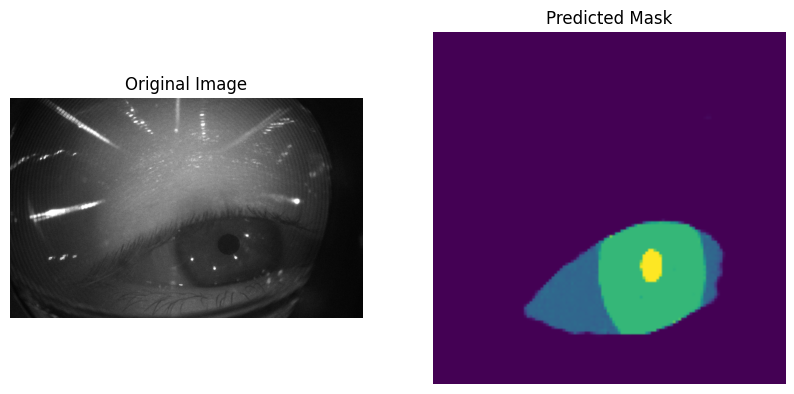

In [54]:
# Define the path to the image you want to predict
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/S_0/150.png'

# image_path = '/home/yasas/GazeEstimation/412.jpg'

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale image
# # Add a batch dimension and a channel dimension (required for model input)
input_image = np.expand_dims(image, axis=0)  # Shape: (1, 256, 256)
input_image = np.expand_dims(input_image, axis=-1)  # Shape: (1, 256, 256, 1)

# Predict the output using the model
# model = load_model('./user_models/unet_gaze_estimation_model_S_0.h5', custom_objects={'dice_loss': dice_loss})

predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (256, 256)

# Apply a threshold to convert the mask to binary (0 and 1) if needed
#predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Display the original image and the predicted mask side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='viridis')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()